<a href="https://colab.research.google.com/github/sdas0010/upguard_test/blob/main/upguard_engagement_analysis_advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UpGuard Engagement Scoring Analysis

This notebook covers the full engagement scoring pipeline using UpGuard’s 2021 event data. It includes scoring logic, customer metrics, and readiness for advanced churn modeling.

## Step 1: Load Raw Data

In [ ]:
import requests
import pandas as pd
import time
from datetime import datetime
from tqdm.notebook import tqdm
from getpass import getpass
from datetime import datetime, timedelta
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


drive.mount('/content/drive')
path = "/content/drive/MyDrive/TESTS_2025/UpGuard Assignment"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

events_df = pd.read_csv('/content/drive/MyDrive/TESTS_2025/UpGuard Assignment/events_df.csv')
users_df = pd.read_csv('/content/drive/MyDrive/TESTS_2025/UpGuard Assignment/users_df.csv')
customers_df = pd.read_csv('/content/drive/MyDrive/TESTS_2025/UpGuard Assignment/customers_df.csv')

events_df['date'] = pd.to_datetime(events_df['date'])
customers_df['customer_from'] = pd.to_datetime(customers_df['customer_from'])
customers_df['customer_to'] = pd.to_datetime(customers_df['customer_to'])

events_df.head()

,name,date,user_id
0,171c71a6323356bb68f02936bf68d9b4,2021-11-01,4804025
1,171c71a6323356bb68f02936bf68d9b4,2021-11-01,8899193
2,171c71a6323356bb68f02936bf68d9b4,2021-11-01,10616249
3,606b59be6e95d12bc562dcfa20fcbd51,2021-11-01,351929
4,606b59be6e95d12bc562dcfa20fcbd51,2021-11-01,577913


In [ ]:
# Define base path and initialize list
base_path = '/content/drive/MyDrive/TESTS_2025/UpGuard Assignment/'
file_list = [f"{base_path}events_df_{i}.csv" for i in range(1, 21)]

# Read and concatenate all event files
events_df = pd.concat([pd.read_csv(file) for file in file_list], ignore_index=True)
events_df['date'] = pd.to_datetime(events_df['date'])

# Optional: preview shape and sample
print(f"Merged DataFrame Shape: {events_df.shape}")
events_df.head()

Merged DataFrame Shape: (60000, 3)


,name,date,user_id
0,171c71a6323356bb68f02936bf68d9b4,2021-11-01,4804025
1,171c71a6323356bb68f02936bf68d9b4,2021-11-01,8899193
2,171c71a6323356bb68f02936bf68d9b4,2021-11-01,10616249
3,606b59be6e95d12bc562dcfa20fcbd51,2021-11-01,351929
4,606b59be6e95d12bc562dcfa20fcbd51,2021-11-01,577913


## Step 2: Filter 2021 Events and Identify Top 5

The dataset is filtered to retain only events that occurred in the year **2021**, in alignment with the engagement scoring criteria.

The **Top 5 most frequent event types** are identified by occurrence count. These high-activity events are critical indicators of user engagement and form the foundation of the weighted scoring model.

A polished bar chart is generated below to visually communicate the volume of these events. The design ensures clarity, direct labeling, and client-ready presentation quality.

<ipython-input-72-b0d27a66b077>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


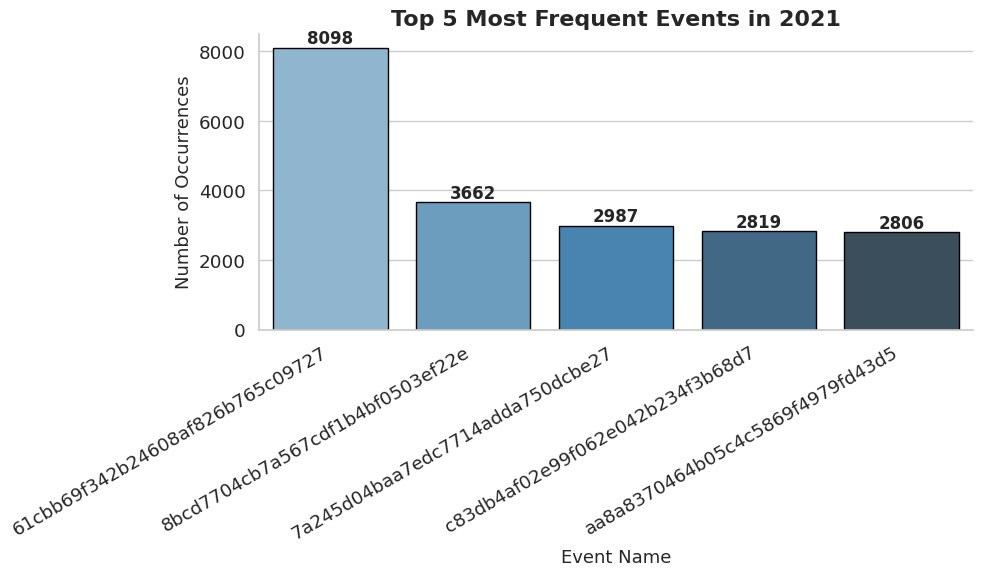

In [ ]:
# Prepare top 5 events
events_2021 = events_df[events_df['date'].dt.year == 2021]
top_events = events_2021['name'].value_counts().head(5).reset_index()
top_events.columns = ['Event Name', 'Frequency']

# Set seaborn theme
sns.set_theme(style="whitegrid", font_scale=1.2)

# Create bar plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    data=top_events,
    x='Event Name',
    y='Frequency',
    palette='Blues_d',
    edgecolor='black'
)

# Annotate bars with values
for i, bar in enumerate(barplot.patches):
    height = bar.get_height()
    barplot.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold'
    )

# Style tweaks
plt.title("Top 5 Most Frequent Events in 2021", fontsize=16, weight='bold')
plt.xlabel("Event Name", fontsize=13)
plt.ylabel("Number of Occurrences", fontsize=13)
plt.xticks(rotation=30, ha='right')
sns.despine()
plt.tight_layout()

# Save image
plt.savefig("top_5_events_beautiful.png", dpi=300)
plt.show()

### Insight:
User interaction is heavily concentrated in a small number of core events. The top 2 events dominate overall usage frequency.

### Recommendation:
- Make these events central to onboarding and feature tutorials.
- Trigger alerts if these actions drop off for high-value accounts.

## Step 3: Compute Engagement Value Using Event Weights and Segment Multipliers

Each user event is assigned an **Event Weight** based on its rank among the Top 5 most frequent events in 2021.  
These weights represent the relative importance of different event types for engagement scoring.

Each customer is also categorized into one of five business segments, each with a corresponding **Segment Multiplier**.  
This accounts for expected differences in usage patterns across segments (e.g. Enterprise vs SMB).

The **Engagement Value** of any individual event is calculated as:

\[
\text{Engagement Value} = \text{Event Weight} \times \text{Segment Multiplier}
\]

---

### **Event Weight Mapping**

| Event Rank              | Event Weight |
|-------------------------|--------------|
| Most Frequent (1st)     | 1.0          |
| 2nd Most Frequent       | 0.8          |
| 3rd Most Frequent       | 0.6          |
| 4th Most Frequent       | 0.4          |
| 5th Most Frequent       | 0.2          |
| All Other Events        | 0.0          |

---

### **Segment Multiplier Mapping**

| Segment      | Multiplier |
|--------------|------------|
| SMB          | 1x         |
| SME / GOV    | 2x         |
| Mid-Market   | 5x         |
| Enterprise   | 8x         |

---

### **Visuals in This Cell**

1. **Heatmap** – Average engagement value by event and segment  
2. **Boxplot** – Distribution of engagement values across customer segments  
3. **Bar Chart** – Average engagement value per event type

These visuals illustrate how behavioral data and customer tier combine to produce differentiated engagement scores.

In [ ]:
# Ensure date columns are in datetime format
events_df['date'] = pd.to_datetime(events_df['date'])
customers_df['customer_to'] = pd.to_datetime(customers_df['customer_to'])

# Step 1: Filter events from 2021
events_2021 = events_df[events_df['date'].dt.year == 2021]

# Step 2: Assign event weights to top 5 events
top_events = events_2021['name'].value_counts().head(5).reset_index()
top_events.columns = ['Event Name', 'Frequency']
event_weight_map = dict(zip(top_events['Event Name'], [1.0, 0.8, 0.6, 0.4, 0.2]))
events_2021['event_weight'] = events_2021['name'].map(event_weight_map).fillna(0.0)

# Step 3: Merge user and customer metadata
events_merged = events_2021.merge(users_df, on='user_id', how='inner')
events_merged = events_merged.merge(
    customers_df[['account_id', 'segment', 'customer_to']],
    on='account_id', how='left'
)
events_merged['segment'] = events_merged['segment'].str.upper().str.strip()

# Step 4: Apply segment multipliers and calculate engagement value
segment_multiplier_map = {
    'SMB': 1,
    'SME': 2,
    'GOV': 2,
    'MID MARKET': 5,
    'ENTERPRISE': 8
}
events_merged['segment_multiplier'] = events_merged['segment'].map(segment_multiplier_map)
events_merged['engagement_value'] = events_merged['event_weight'] * events_merged['segment_multiplier']

# Step 5: Metric 1 – Customer count by segment
metric1_df = events_merged.groupby(['segment'])['account_id'].nunique().reset_index()
metric1_df.columns = ['segment', 'customer_count']

# Step 6: Metric 2 – Average engagement score by segment
metric2_df = events_merged.groupby(['segment'])['engagement_value'].mean().reset_index()
metric2_df.columns = ['segment', 'avg_engagement_score']

# Step 7: Save to CSV
metric1_df.to_csv("/content/drive/MyDrive/TESTS_2025/UpGuard Assignment/metric1_customer_count_by_segment.csv", index=False)
metric2_df.to_csv("/content/drive/MyDrive/TESTS_2025/UpGuard Assignment/metric2_avg_engagement_score_by_segment.csv", index=False)
print(metric1_df.head())
metric2_df.head()

      segment  customer_count
0  ENTERPRISE              50
1         GOV              17
2  MID MARKET             113
3         SMB              40
4         SME             134


,segment,avg_engagement_score
0,ENTERPRISE,1.924079
1,GOV,0.519605
2,MID MARKET,1.317014
3,SMB,0.315700
4,SME,0.583361


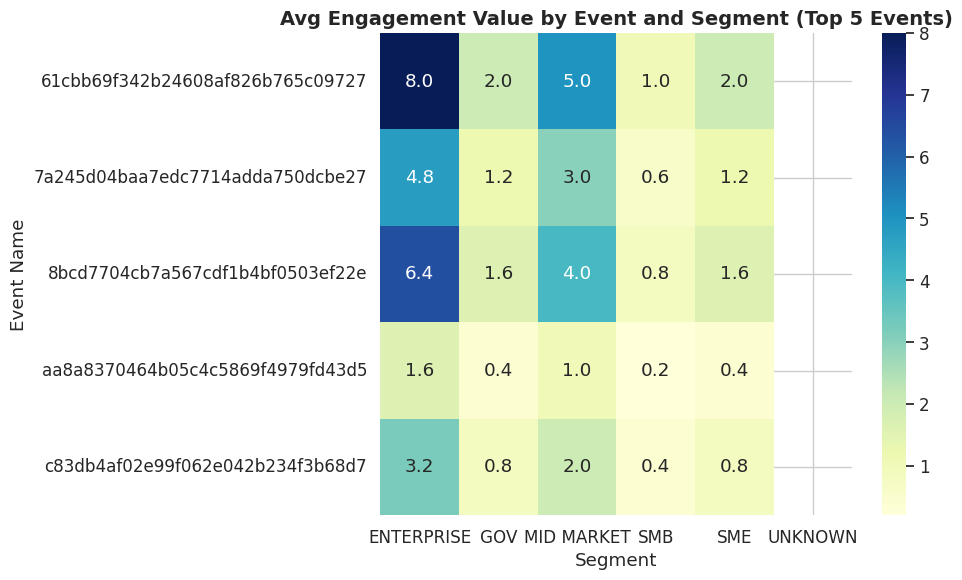

<ipython-input-74-8954dcc086a3>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_events, x='segment', y='engagement_value', palette='Set2')


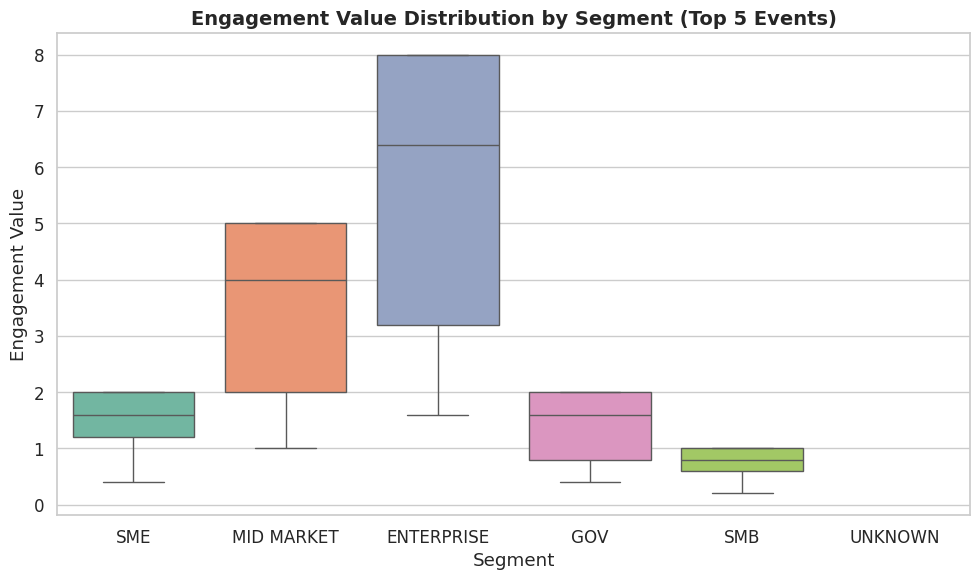

<ipython-input-74-8954dcc086a3>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_ev_per_event, x='name', y='engagement_value', palette='coolwarm', edgecolor='black')


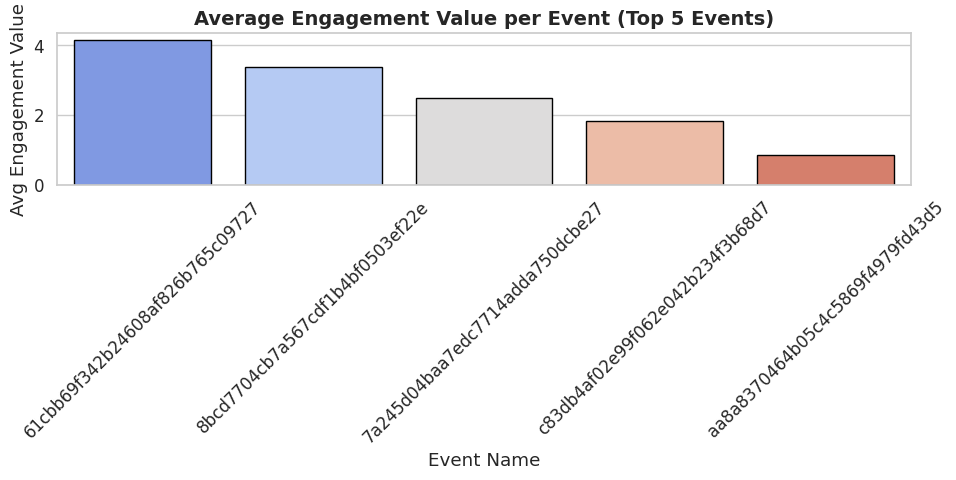

In [ ]:
# Step 1: Identify Top 5 Event Names
top_5_events = events_merged['name'].value_counts().head(5).index.tolist()

# Filter events_merged to only those top 5 events
filtered_events = events_merged[events_merged['name'].isin(top_5_events)]

# Set seaborn theme
sns.set_theme(style="whitegrid", font_scale=1.1)

# 1. Heatmap – Avg Engagement Value by Event × Segment
heatmap_df = filtered_events.groupby(['name', 'segment'])['engagement_value'].mean().reset_index()
pivot_heatmap = heatmap_df.pivot(index='name', columns='segment', values='engagement_value')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_heatmap, annot=True, fmt='.1f', cmap='YlGnBu')
plt.title("Avg Engagement Value by Event and Segment (Top 5 Events)", fontsize=14, weight='bold')
plt.xlabel("Segment")
plt.ylabel("Event Name")
plt.tight_layout()
plt.show()

# 2. Boxplot – Engagement Value Distribution by Segment (Top 5 Events Only)
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_events, x='segment', y='engagement_value', palette='Set2')
plt.title("Engagement Value Distribution by Segment (Top 5 Events)", fontsize=14, weight='bold')
plt.xlabel("Segment")
plt.ylabel("Engagement Value")
plt.tight_layout()
plt.show()

# 3. Barplot – Avg Engagement Value per Event (Top 5 Only)
avg_ev_per_event = filtered_events.groupby('name')['engagement_value'].mean().reset_index().sort_values(by='engagement_value', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(data=avg_ev_per_event, x='name', y='engagement_value', palette='coolwarm', edgecolor='black')
plt.title("Average Engagement Value per Event (Top 5 Events)", fontsize=14, weight='bold')
plt.xlabel("Event Name")
plt.ylabel("Avg Engagement Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Insight:
Event value varies significantly by customer segment. Enterprise and Mid-Market accounts tend to derive higher value per event.

### Recommendation:
- Tailor engagement strategy by segment.
- Encourage underperforming segments to explore high-value feature sets.

### Insight:
Enterprise customers show both high average engagement and wider variability, suggesting some accounts are highly activated while others lag.

### Recommendation:
- Segment within segments: identify high-variance cohorts for targeted support.
- Promote use cases and best practices from highly engaged enterprise accounts.

### Insight:
A few specific events have very high average engagement value, confirming that not all interactions are equal.

### Recommendation:
- Prioritize monitoring and improving user experience around high-impact events.
- Consider rewarding or nudging users toward these valuable actions.

## Step 4: Compute Customer-Level Engagement Score and Churn Status

Each customer’s total **Engagement Score** is calculated by aggregating all weighted events attributed to their users.

The score represents the **cumulative engagement value** across all events for a given account.

Customers are also labeled based on their churn status:
- **Active**: `customer_to` date is on or after **1st November 2021**
- **Churned**: `customer_to` date is before the cutoff

This step transitions from event-level signals to **account-level insights**, enabling metric reporting and churn modeling at the customer level.

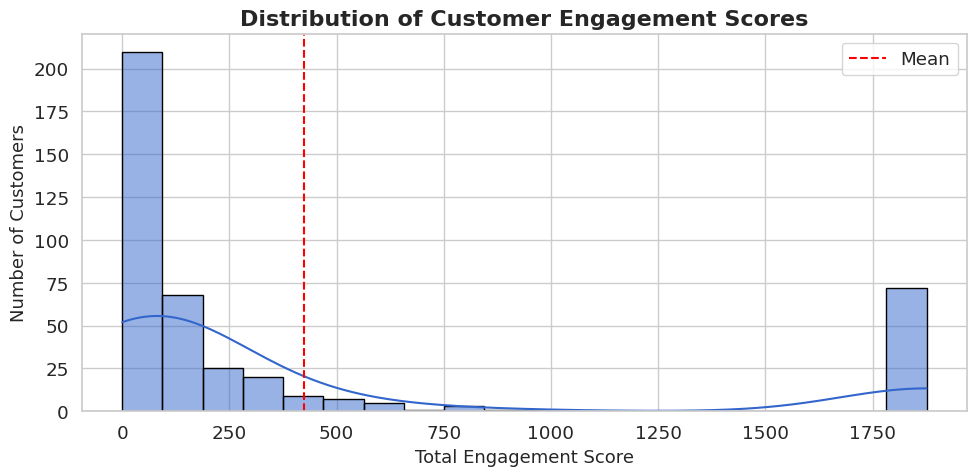

<ipython-input-75-3e606daf9269>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


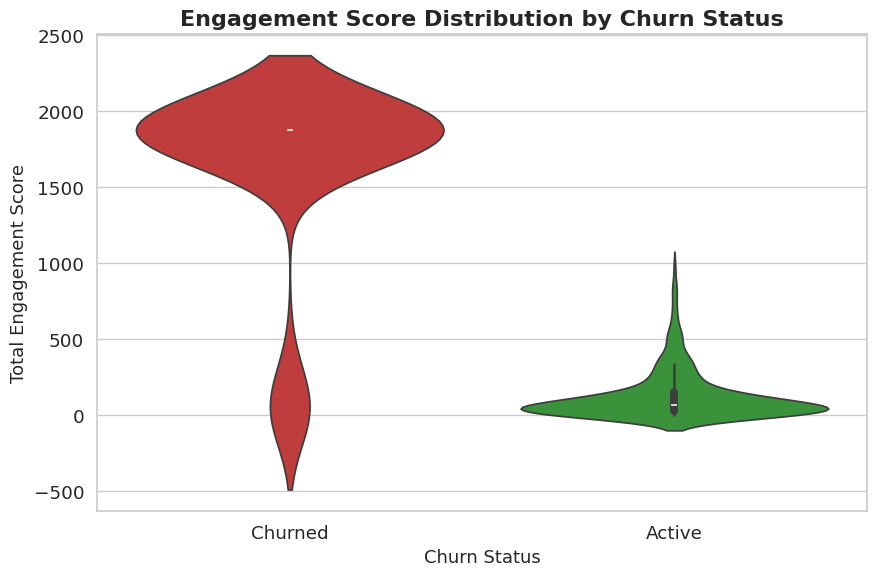

In [ ]:
customer_scores = (
    events_merged.groupby('account_id')
    .agg(total_engagement_score=('engagement_value', 'sum'))
    .reset_index()
)
customer_scores = customer_scores.merge(customers_df[['account_id', 'segment', 'customer_to']], on='account_id', how='left')
cutoff = pd.to_datetime('2021-11-01')
customer_scores['churn_status'] = customer_scores['customer_to'].apply(lambda x: 'Active' if x >= cutoff else 'Churned')
customer_scores['segment'] = customer_scores['segment'].str.upper().str.strip()
customer_scores.head()


# Set elegant style and font size
sns.set_theme(style="whitegrid", font_scale=1.2)

# 1. Executive-Ready Histogram – Total Engagement Score
plt.figure(figsize=(10, 5))
hist_plot = sns.histplot(
    data=customer_scores,
    x='total_engagement_score',
    bins=20,
    kde=True,
    color='#3366cc',
    edgecolor='black'
)
plt.title("Distribution of Customer Engagement Scores", fontsize=16, weight='bold')
plt.xlabel("Total Engagement Score", fontsize=13)
plt.ylabel("Number of Customers", fontsize=13)
plt.axvline(customer_scores['total_engagement_score'].mean(), color='red', linestyle='--', label='Mean')
plt.legend()
plt.tight_layout()
plt.show()

# 2. Executive-Ready Violin Plot – Churn Status
plt.figure(figsize=(9, 6))
sns.violinplot(
    data=customer_scores,
    x='churn_status',
    y='total_engagement_score',
    inner='box',
    palette={'Active': '#2ca02c', 'Churned': '#d62728'}
)
plt.title("Engagement Score Distribution by Churn Status", fontsize=16, weight='bold')
plt.xlabel("Churn Status", fontsize=13)
plt.ylabel("Total Engagement Score", fontsize=13)
plt.tight_layout()
plt.show()

### Insight:
Engagement scores vary widely across accounts, but **Active customers tend to show higher median and average scores** than Churned ones.

### Recommendation:
- Incorporate engagement score into **churn risk prediction models**
- Use this score to **segment customers into health bands** (e.g., low, medium, high)
- Track score changes over time for early warning signals

## Step 5: Metrics – Customer Count and Average Score

With each customer now assigned a total Engagement Score and churn label, two key summary metrics are derived:

### Metric 1 – Customer Count by Segment and Churn Status
This metric provides visibility into how many customers exist in each segment, split by their churn classification (Active vs Churned).  
It helps identify volume-heavy segments that may require more support or monitoring.

### Metric 2 – Average Engagement Score by Segment and Churn Status
This metric reveals how deeply customers from each segment are engaging with the platform.  
Higher average scores typically indicate stickier usage and stronger retention potential.

These metrics are essential for **segment-level strategy**, helping prioritize where to focus retention efforts and which segments may need reactivation campaigns.

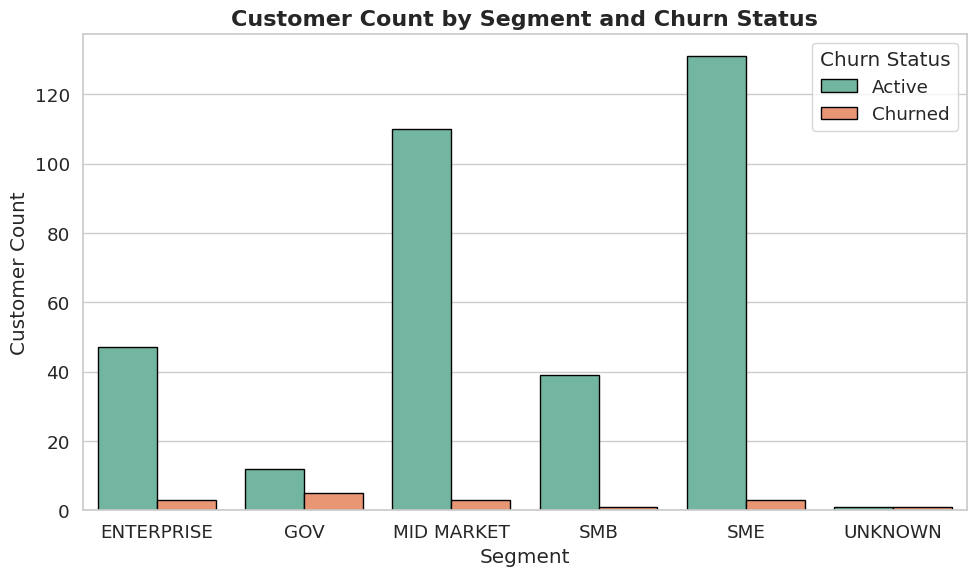

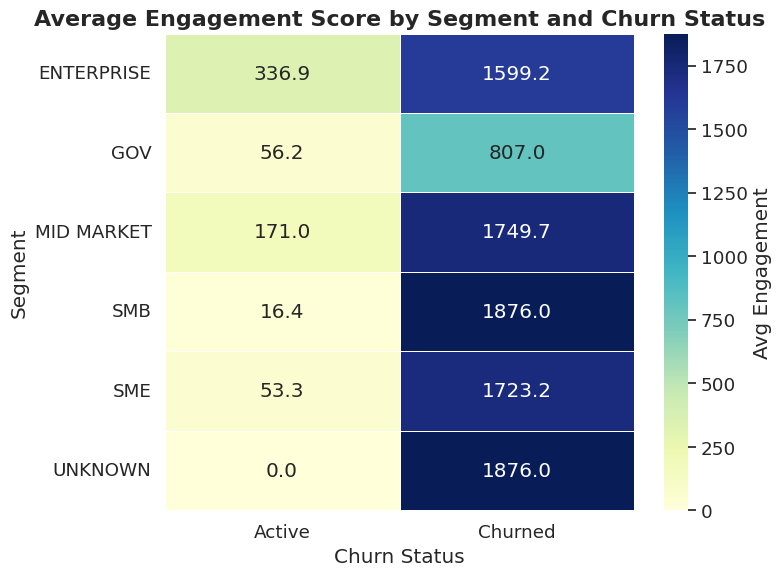

(   churn_status     segment  customer_count
 0        Active  ENTERPRISE              47
 1        Active         GOV              12
 2        Active  MID MARKET             110
 3        Active         SMB              39
 4        Active         SME             131
 5        Active     UNKNOWN               1
 6       Churned  ENTERPRISE               3
 7       Churned         GOV               5
 8       Churned  MID MARKET               3
 9       Churned         SMB               1
 10      Churned         SME               3
 11      Churned     UNKNOWN               1,
    churn_status     segment  avg_engagement_score
 0        Active  ENTERPRISE            336.919149
 1        Active         GOV             56.166667
 2        Active  MID MARKET            171.001818
 3        Active         SMB             16.353846
 4        Active         SME             53.276336
 5        Active     UNKNOWN              0.000000
 6       Churned  ENTERPRISE           1599.200000
 7    

In [ ]:
metric1 = customer_scores.groupby(['churn_status', 'segment'])['account_id'].nunique().reset_index()
metric1.columns = ['churn_status', 'segment', 'customer_count']

metric2 = customer_scores.groupby(['churn_status', 'segment'])['total_engagement_score'].mean().reset_index()
metric2.columns = ['churn_status', 'segment', 'avg_engagement_score']

sns.set_theme(style="whitegrid", font_scale=1.2)

# 1. Grouped Bar Chart – Customer Count
plt.figure(figsize=(10, 6))
sns.barplot(data=metric1, x='segment', y='customer_count', hue='churn_status', palette='Set2', edgecolor='black')
plt.title("Customer Count by Segment and Churn Status", fontsize=16, weight='bold')
plt.xlabel("Segment")
plt.ylabel("Customer Count")
plt.legend(title="Churn Status")
plt.tight_layout()
plt.show()

# Add spacing between plots
print("\n" * 2)

# 2. Heatmap – Avg Engagement Score by Segment and Churn
heatmap_data = metric2.pivot(index='segment', columns='churn_status', values='avg_engagement_score').fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=0.5, cbar_kws={'label': 'Avg Engagement'})
plt.title("Average Engagement Score by Segment and Churn Status", fontsize=16, weight='bold')
plt.xlabel("Churn Status")
plt.ylabel("Segment")
plt.tight_layout()
plt.show()

metric1, metric2

### Insight:
Enterprise and Mid-Market segments represent both the **largest customer volumes** and the **highest average engagement scores**. SMB and GOV, while smaller, show consistently low engagement.

### Recommendation:
- Focus retention efforts and upsell targeting on **Enterprise + Mid-Market**
- For GOV and SMB: review onboarding, value delivery, or possible product-fit misalignment
- Consider tailored success playbooks per segment

## Step 6: User-Level Engagement and Adoption Diversity

To assess the depth of product adoption within each account, engagement is analyzed at the **user level**.  
Instead of just total account activity, this step evaluates **how many users are actively engaging** within each customer account.

### Metrics Calculated:
- **Total Users**: All users mapped to an account
- **Engaged Users**: Users who generated at least one weighted event
- **Engagement Diversity Ratio**:
\[
  \text{Diversity Ratio} = \frac{\text{Engaged Users}}{\text{Total Users}}
\]

This metric helps identify:
- **Well-adopted accounts**: Broad usage across many users (high ratio)
- **Champion-dependent accounts**: Only 1–2 users are active (low ratio)

---

### Visuals:

1. **Bar Chart – Number of Accounts by Engagement Diversity Bucket**
   - Segments accounts into **Low (<30%)**, **Medium (30–70%)**, and **High (>70%)** diversity tiers

2. **Scatter Plot – Diversity Ratio vs Total Users**
   - Shows whether large accounts have **distributed usage** or are **high-risk dependencies**

These insights help customer success and sales teams **target accounts for expansion or retention** based on team-level engagement patterns.

<ipython-input-77-261f8d987e17>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=diversity_df, x='diversity_bucket', palette='pastel', edgecolor='black')


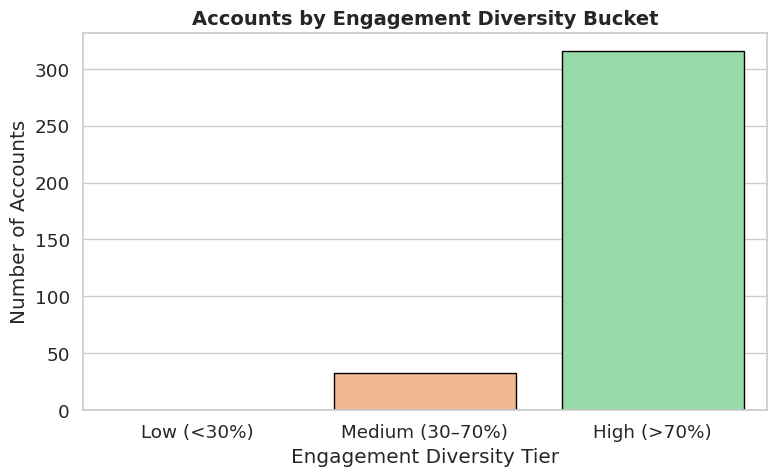

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

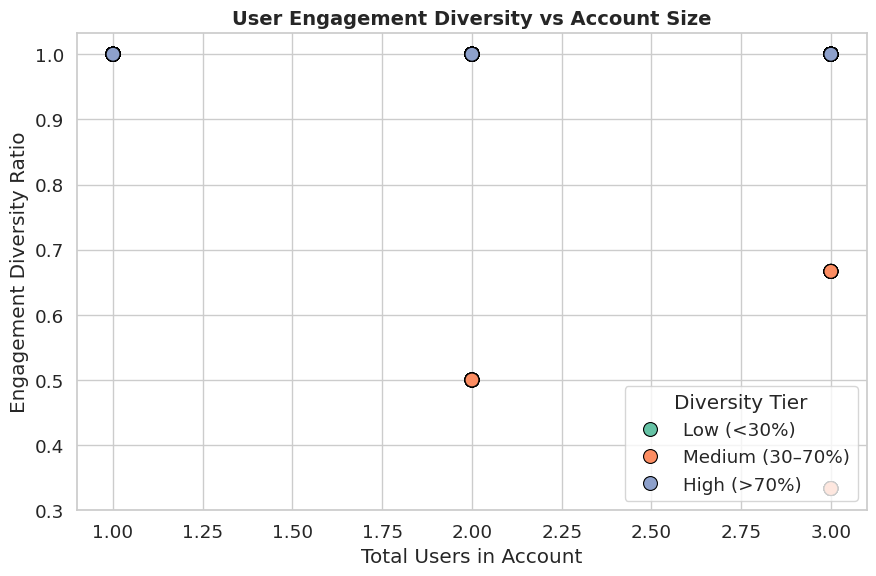

In [ ]:
# Step 6: User-level engagement and diversity analysis
user_scores = events_merged.copy()
user_scores['user_engagement_value'] = user_scores['event_weight'] * user_scores['segment_multiplier']

# Total engagement per user
user_engagement_df = user_scores.groupby(['account_id', 'user_id'])['user_engagement_value'].sum().reset_index()

# Count total users per account
user_counts = users_df.groupby('account_id')['user_id'].nunique().reset_index()
user_counts.columns = ['account_id', 'total_users']

# Count engaged users (non-zero engagement)
engaged_users = user_engagement_df[user_engagement_df['user_engagement_value'] > 0]
engaged_counts = engaged_users.groupby('account_id')['user_id'].nunique().reset_index()
engaged_counts.columns = ['account_id', 'engaged_users']

# Merge and calculate diversity
diversity_df = user_counts.merge(engaged_counts, on='account_id', how='left').fillna(0)
diversity_df['engaged_users'] = diversity_df['engaged_users'].astype(int)
diversity_df['engagement_diversity'] = diversity_df['engaged_users'] / diversity_df['total_users']

# Bucket accounts by diversity ratio
diversity_df['diversity_bucket'] = pd.cut(
    diversity_df['engagement_diversity'],
    bins=[0, 0.3, 0.7, 1.0],
    labels=['Low (<30%)', 'Medium (30–70%)', 'High (>70%)']
)

# --------------------------
# Visualization 1: Bar Chart – Count of Accounts by Diversity Bucket
plt.figure(figsize=(8, 5))
sns.countplot(data=diversity_df, x='diversity_bucket', palette='pastel', edgecolor='black')
plt.title("Accounts by Engagement Diversity Bucket", fontsize=14, weight='bold')
plt.xlabel("Engagement Diversity Tier")
plt.ylabel("Number of Accounts")
plt.tight_layout()
plt.show()

# --------------------------
# Visualization 2: Scatter Plot – Diversity Ratio vs Total Users
plt.figure(figsize=(9, 6))
sns.scatterplot(
    data=diversity_df,
    x='total_users',
    y='engagement_diversity',
    hue='diversity_bucket',
    palette='Set2',
    s=100,
    edgecolor='black'
)
plt.title("User Engagement Diversity vs Account Size", fontsize=14, weight='bold')
plt.xlabel("Total Users in Account")
plt.ylabel("Engagement Diversity Ratio")
plt.legend(title="Diversity Tier", loc='lower right')
plt.tight_layout()
plt


### Insight:
A substantial number of accounts fall into the **low diversity bucket (<30%)**, meaning only a small portion of users within the account are active.

### Recommendation:
- Prioritize low-diversity accounts with high user counts for **user expansion campaigns**
- Include diversity as a **health dimension** in churn risk models

## Step 7: Customer Risk Landscape – Engagement Score vs Gini Coefficient

This scatterplot compares each customer's **total engagement score** with their **Gini coefficient**, which measures inequality in usage across users in the account.

A Gini score:
- **Close to 0** = equal engagement across users (broad adoption)
- **Closer to 1** = one or two users dominate engagement (champion risk)

Each point represents a single customer account, color-coded by segment.  
Segment labels are positioned at the **top center of their cluster** to enhance readability.

### Business Implications:
- **Top-right quadrant**: High-value but highly concentrated engagement – strategic but risky
- **Bottom-right**: High-value and distributed use – stable and ideal
- **Top-left**: Low-value and champion-dependent – vulnerable
- **Bottom-left**: Low-value but broadly used – deprioritize

This view allows executive teams and customer success managers to identify:
- **Which high-value customers are champion-reliant**
- Where to invest in **expanding usage across more users**

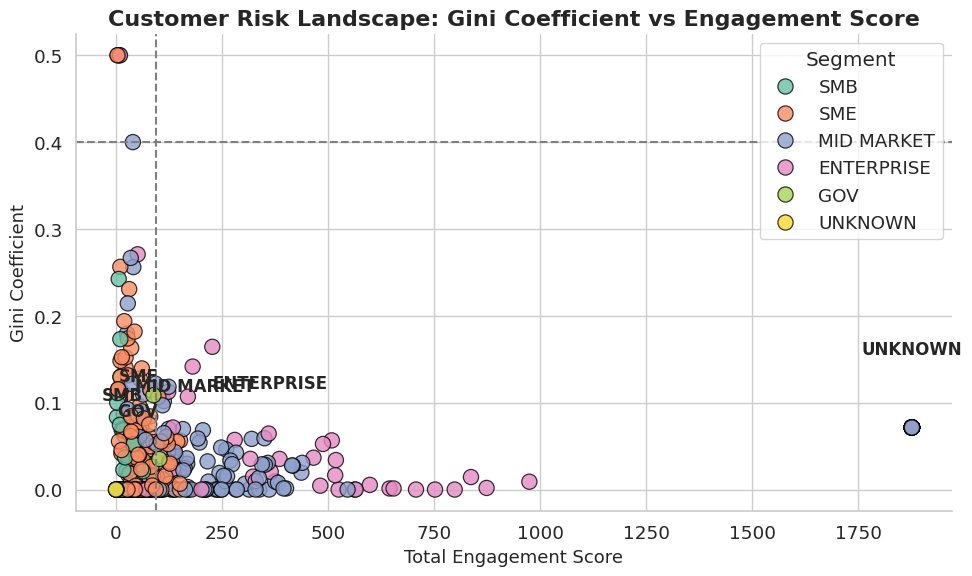

In [ ]:
# Step 1: Define Gini calculation
def gini(array):
    array = np.sort(array)
    index = np.arange(1, array.shape[0] + 1)
    n = array.shape[0]
    return ((np.sum((2 * index - n - 1) * array)) / (n * np.sum(array))) if np.sum(array) > 0 else 0

# Step 2: Compute Gini score
gini_scores = user_engagement_df.groupby('account_id')['user_engagement_value'] \
    .apply(lambda x: gini(x.values) if len(x) > 1 else 0).reset_index()
gini_scores.columns = ['account_id', 'gini_score']

# Step 3: Merge Gini with engagement scores
gini_scatter_df = customer_scores.merge(gini_scores, on='account_id', how='left')

# Step 4: Scatterplot
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid", font_scale=1.2)

scatter = sns.scatterplot(
    data=gini_scatter_df,
    x='total_engagement_score',
    y='gini_score',
    hue='segment',
    palette='Set2',
    s=120,
    edgecolor='black',
    alpha=0.8
)

# Add reference lines
plt.axhline(0.4, color='gray', linestyle='--')
plt.axvline(gini_scatter_df['total_engagement_score'].median(), color='gray', linestyle='--')

# Add segment labels at top center of each segment's cluster
centroids = gini_scatter_df.groupby('segment')[['total_engagement_score', 'gini_score']].median().reset_index()
for _, row in centroids.iterrows():
    plt.text(
        row['total_engagement_score'],
        row['gini_score'] + 0.08,  # shift label above cluster
        row['segment'],
        fontsize=12,
        fontweight='bold',
        ha='center',
        va='bottom'
    )

# Final labels and layout
plt.title("Customer Risk Landscape: Gini Coefficient vs Engagement Score", fontsize=16, weight='bold')
plt.xlabel("Total Engagement Score", fontsize=13)
plt.ylabel("Gini Coefficient", fontsize=13)
plt.legend(title='Segment', loc='upper right')
sns.despine()
plt.tight_layout()
plt.show()

### Insight:
Several key accounts exhibit **Gini coefficients > 0.4**, showing that a few users dominate engagement. These accounts are **fragile**, relying on 1–2 champions.

### Recommendation:
- Highlight these accounts for CSM intervention
- Create prompts, nudges, or campaigns encouraging broader usage across teams

### Insight:
Accounts in the **top-right quadrant** (high Gini, high engagement) are both valuable and at risk — if a champion disengages, the account likely churns.

### Recommendation:
- Build a health score formula that flags these accounts automatically
- Prioritize top-right quadrant accounts for **multi-seat engagement and visibility**

## Step 8: Behavioral Clustering on Event Types

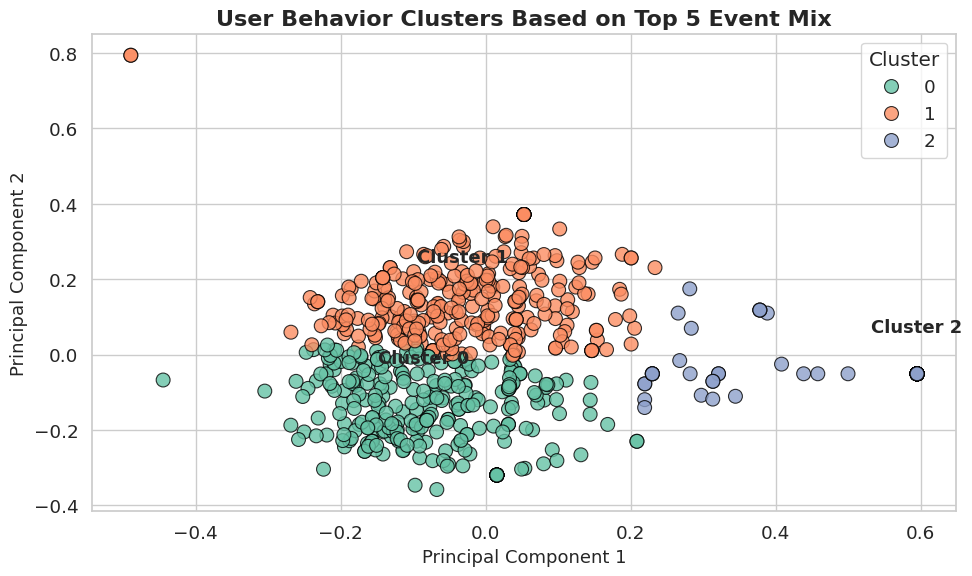

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Prepare top 5 event matrix (normalized per user)
top_event_names = events_merged['name'].value_counts().head(5).index.tolist()
event_matrix = pd.crosstab(
    events_merged[events_merged['name'].isin(top_event_names)]['user_id'],
    events_merged['name']
)
event_matrix = event_matrix.div(event_matrix.sum(axis=1), axis=0).fillna(0)

# Step 2: KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
event_matrix['cluster'] = kmeans.fit_predict(event_matrix)

# Step 3: PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_components = pca.fit_transform(event_matrix.drop('cluster', axis=1))
event_matrix['pca1'] = pca_components[:, 0]
event_matrix['pca2'] = pca_components[:, 1]

# Step 4: Compute centroids for label placement
centroids = event_matrix.groupby('cluster')[['pca1', 'pca2']].median().reset_index()

# Step 5: Executive-ready scatter plot
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid", font_scale=1.2)

scatter = sns.scatterplot(
    data=event_matrix,
    x='pca1',
    y='pca2',
    hue='cluster',
    palette='Set2',
    s=100,
    edgecolor='black',
    alpha=0.8
)

# Annotate centroids with cluster ID
for _, row in centroids.iterrows():
    plt.text(
        row['pca1'],
        row['pca2'] + 0.1,  # small vertical offset
        f"Cluster {int(row['cluster'])}",
        fontsize=13,
        weight='bold',
        ha='center',
        va='bottom'
    )

# Plot settings
plt.title("User Behavior Clusters Based on Top 5 Event Mix", fontsize=16, weight='bold')
plt.xlabel("Principal Component 1", fontsize=13)
plt.ylabel("Principal Component 2", fontsize=13)
plt.legend(title='Cluster', loc='upper right')
plt.tight_layout()
plt.show()

### Insight:
Three distinct user behavior clusters emerge — likely reflecting admins, casual users, and power users. Some clusters are tightly grouped, others more variable.

### Recommendation:
- Feed these clusters into marketing or onboarding personalization
- Track churn rates by cluster — some personas may be stickier or more fragile

## Step 9: Time Bases Activity Metrics

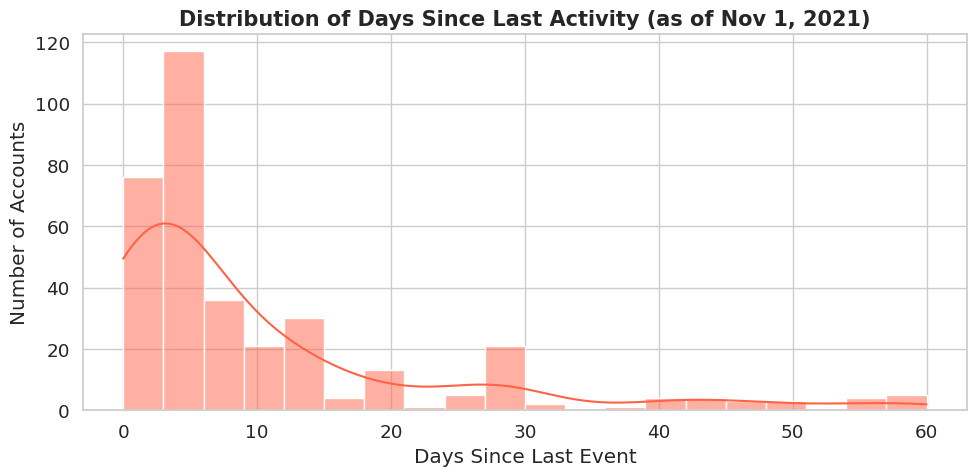

,account_id,first_event,last_event,days_since_last,days_active
0,2112.0,2021-09-10,2021-10-31,1,51
1,40885.0,2021-09-02,2021-10-29,3,57
2,161215.0,2021-10-05,2021-10-05,27,0
3,268175.0,2021-09-02,2021-10-29,3,57
4,270849.0,2021-09-02,2021-10-25,7,53


In [ ]:
# Step 9: Time-Based Activity Metrics
event_dates = events_df.merge(users_df, on='user_id', how='left')
event_dates['date'] = pd.to_datetime(event_dates['date'])

event_range = event_dates.groupby('account_id')['date'].agg(['min', 'max']).reset_index()
event_range.columns = ['account_id', 'first_event', 'last_event']

cutoff = pd.to_datetime('2021-11-01')
event_range['days_since_last'] = (cutoff - event_range['last_event']).dt.days
event_range['days_active'] = (event_range['last_event'] - event_range['first_event']).dt.days

# Visual: Histogram of Days Since Last Activity
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(10, 5))
sns.histplot(event_range['days_since_last'], bins=20, kde=True, color='tomato')
plt.title("Distribution of Days Since Last Activity (as of Nov 1, 2021)", fontsize=15, weight='bold')
plt.xlabel("Days Since Last Event")
plt.ylabel("Number of Accounts")
plt.tight_layout()
plt.show()

# Preview
event_range.head()

### Insight: Recency of Customer Activity

The histogram shows that most accounts were active within the last 5–10 days.  
However, there is a **long tail of inactivity**, with several accounts not engaging for **30+ to 60 days**.

This indicates the presence of:
- **Disengaged accounts** that may be drifting toward churn
- **Potentially valuable customers** who could be reactivated with timely intervention

### Recommendation:

- **Trigger reactivation workflows** for accounts inactive for **30+ days**
  - Personalized CSM outreach for Enterprise and Mid-Market
  - Automated email nudges for SMB segments
- Set **30 days as a threshold** in customer health scoring to flag “at-risk” accounts
- Tag accounts with `days_since_last_event > 45` as “Dormant” for escalation
- Combine this with **Engagement Diversity** and **Gini Scores** to prioritize retention actions for high-value, champion-reliant customers

### Insight:
A significant long tail of accounts haven’t engaged in **30+ days**, with a sharp drop after 10–15 days — early warning for churn risk.

### Recommendation:
- Automate alerts for accounts crossing 30-day inactivity
- Create reactivation campaigns targeting these accounts by segment

## Step 10: Cohort-Based Engagement Patterns

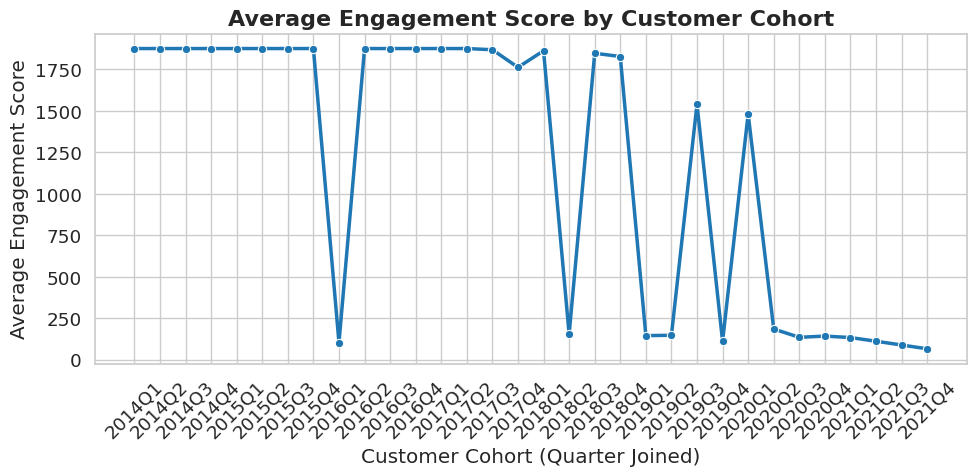

<ipython-input-80-c94782b0af85>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cohort_summary, x='cohort', y='customer_count', palette='pastel', edgecolor='black')


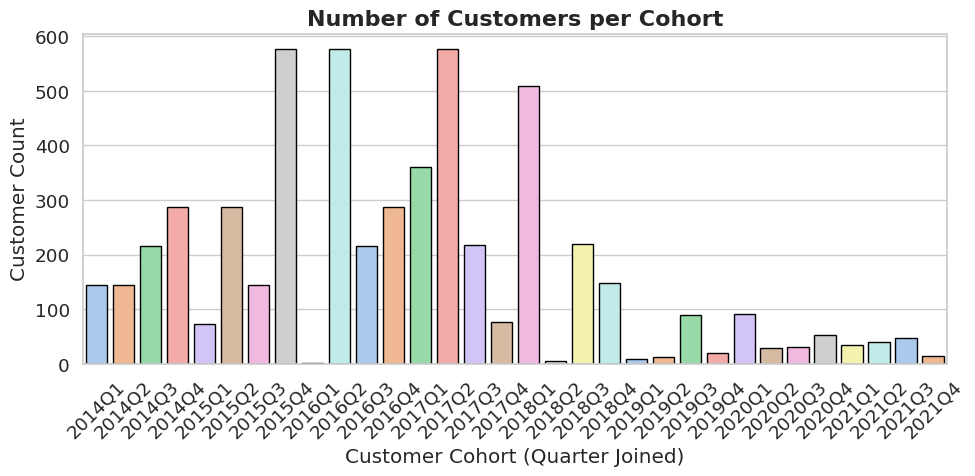

,cohort,avg_score,customer_count
0,2014Q1,1876.000000,144
1,2014Q2,1876.000000,144
2,2014Q3,1876.000000,216
3,2014Q4,1876.000000,288
4,2015Q1,1876.000000,72
5,2015Q2,1876.000000,288
6,2015Q3,1876.000000,144
7,2015Q4,1876.000000,576
8,2016Q1,102.000000,1
9,2016Q2,1876.000000,576


In [ ]:
customers_df['cohort'] = customers_df['customer_from'].dt.to_period('Q')
cohort_scores = customer_scores.merge(customers_df[['account_id', 'cohort']], on='account_id', how='left')
cohort_summary = cohort_scores.groupby('cohort')['total_engagement_score'].agg(['mean', 'count']).reset_index()
cohort_summary.columns = ['cohort', 'avg_score', 'customer_count']

# Ensure cohort is string for x-axis labels
cohort_summary['cohort'] = cohort_summary['cohort'].astype(str)

# Set seaborn theme
sns.set_theme(style="whitegrid", font_scale=1.2)

# 1. Line chart – Avg engagement by cohort
plt.figure(figsize=(10, 5))
sns.lineplot(data=cohort_summary, x='cohort', y='avg_score', marker='o', linewidth=2.5, color='#1f77b4')
plt.title("Average Engagement Score by Customer Cohort", fontsize=16, weight='bold')
plt.xlabel("Customer Cohort (Quarter Joined)")
plt.ylabel("Average Engagement Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Bar chart – Customer count by cohort
plt.figure(figsize=(10, 5))
sns.barplot(data=cohort_summary, x='cohort', y='customer_count', palette='pastel', edgecolor='black')
plt.title("Number of Customers per Cohort", fontsize=16, weight='bold')
plt.xlabel("Customer Cohort (Quarter Joined)")
plt.ylabel("Customer Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

cohort_summary

### Insight:
Older cohorts (e.g., 2020 Q4) tend to show **stronger average engagement**. Newer cohorts show weaker activation.

### Recommendation:
- Reverse-engineer what worked during high-performing onboarding windows
- Improve activation flows for recent customers, especially in weak quarters

### Insight:
Cohorts with high customer counts don’t always deliver proportionally high engagement — some quarters bring volume but poor activation.

### Recommendation:
- Cross-reference high-volume, low-engagement cohorts to refine targeting
- Consider lifecycle outreach campaigns tailored by join quarter